# 0.0. IMPORTS

In [1]:
import inflection
import warnings

import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap
import regex      as re

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from matplotlib          import pyplot        as plt
from sklearn             import cluster       as c
from sklearn             import metrics       as m
from plotly              import express       as px
from sklearn             import preprocessing as pp

# hide warnings
warnings.filterwarnings("ignore")

C:\Users\mathe\anaconda3\envs\insiders_clustering\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mathe\anaconda3\envs\insiders_clustering\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\mathe\anaconda3\envs\insiders_clustering\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\mathe\anaconda3\envs\insiders_clustering\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1. Aux Functions

## 0.2. Data Collection

In [2]:
# reading data
df = pd.read_csv( "datasets/Ecommerce.csv", encoding='unicode_escape' )

# removing unnamed column
df = df.drop( columns=['Unnamed: 8'] )

# 1.0. DATA DESCRIPTION

In [3]:
df1 = df.copy()

## 1.1. Columns Description

In [4]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

- **InvoiceNo**: Invoice number (A 6-digit integral number uniquely assigned to each transaction)

- **StockCode**: Product code

- **Description**: Product name

- **Quantity**: The quantities of each product per transaction

- **InvoiceDate**: The day when each transaction was generated

- **UnitPrice**: Product price per unit

- **CustomerID**: Customer number (Unique ID assigned to each customer)

- **Country**: Country name (The name of the country where each customer resides)

### 1.1.1. Rename columns

In [5]:
cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
        'UnitPrice', 'CustomerID', 'Country']

# camelcase cols to snakecase
snakecase = lambda x: inflection.underscore( x )
new_cols = list( map( snakecase , cols ) )
new_cols

# renaming cols
df1.columns = new_cols

## 1.2. Data Dimensions

In [6]:
print( f'Number of rows: { df1.shape[0]}' )
print( f'Number of columns: { df1.shape[1]}' )

Number of rows: 541909
Number of columns: 8


## 1.3. NA check

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.3.1. Na Fullfill

In [8]:
df1 = df1.dropna( subset=['description','customer_id'] )

## 1.4. Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4.1. Change data types

In [10]:
# customer_id
df1['customer_id'] = df1['customer_id'].astype( 'int64' )

# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

## 1.5. Descriptive Statistics

In [11]:
df_num = df1[['quantity','unit_price']]
df_cat = df1.select_dtypes( exclude=['float64','int64','datetime64[ns]'] )

### 1.5.1. Numerical Attributes

In [12]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# central tendency - mean, median
ct1 = pd.DataFrame( df_num.apply( lambda x: np.mean( x ) ) ).T
ct2 = pd.DataFrame( df_num.apply( lambda x: np.median( x ) ) ).T

# dispersion metrics - min, max, range, std, skewness, kurtosis
dm1 = pd.DataFrame( df_num.apply( lambda x: np.min( x ) ) ).T
dm2 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) ) ).T
dm3 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) - np.min( x ) ) ).T
dm4 = pd.DataFrame( df_num.apply( lambda x: np.std( x ) ) ).T
dm5 = pd.DataFrame( df_num.apply( lambda x: x.skew() ) ).T
dm6 = pd.DataFrame( df_num.apply( lambda x: x.kurtosis() ) ).T

# concat
df_descriptive = pd.concat( [ dm1, dm2, dm3, ct1, ct2, dm4, dm5, dm6 ] ).T
df_descriptive.columns = ( 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis' )
df_descriptive

,min,max,range,mean,median,std,skewness,kurtosis
quantity,-80995.00,80995.00,161990.00,12.06,5.00,248.69,0.18,94317.56
unit_price,0.00,38970.00,38970.00,3.46,1.95,69.32,452.22,246924.54


#### Problems

- Negative **quantity**

- High value **quantity** ( 80995 )

- **unit_price** = 0

### 1.5.2. Categorical Attributes

#### invoice_no ( should be int )

In [13]:
#df_cat['invoice_no'].astype( 'int64' )
invoice_no_with_strings = len(df_cat.loc[df_cat['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'] )
print( f'Invoice number with strings: {invoice_no_with_strings}' )

Invoice number with strings: 8905


#### stock_code ( should be int )

In [14]:
stock_code_with_strings = len(df_cat.loc[df_cat['stock_code'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'stock_code'].drop_duplicates() )
print( f'Stock code with strings: {stock_code_with_strings}' )

Stock code with strings: 886


In [15]:
df_cat.loc[df_cat['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()
#df_cat.loc[df_cat['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), :].head()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [16]:
len(df_cat.loc[df_cat['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'])

1774

#### description

In [17]:
df_cat.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### country

In [18]:
df_cat['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [19]:
df_cat['country'].value_counts( normalize=True ).head()

United Kingdom   0.89
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.01
Name: country, dtype: float64

In [20]:
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values( 'customer_id', ascending=False ).head()

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


#### Problems

- **Invoice number** with strings

- **Stock code** with strings

- **Stock code** only with strings: 'POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'

- Useless feature **'description'**

# 2.0. DATA FILTERING

In [21]:
df2 = df1.copy()

In [22]:
# description
df2 = df2.drop( columns=['description'] ) # Useless feature 'description'

# unit_price
df2 = df2[df2['unit_price'] >= 0.04] # unit_price = 0

# stock code
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'] ) ] # Stock code only with strings: 'POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'

# country 
df2 = df2[~df2['country'].isin( ['European Community','Unspecified'] ) ] # google latitudes

# quantity
df_return = df2[ df2['quantity'] < 0 ] # quantity < 0
df_purchase = df2[ df2['quantity'] >=0 ]

In [23]:
perc_lost = 100 * ( df_return.shape[0] / ( df_return.shape[0] + df_purchase.shape[0] ) )
print( 'Lost {:.2f}% of database with data filtering'.format( perc_lost ) ) 


Lost 2.11% of database with data filtering


# 3.0. FEATURE ENGINEERING

In [24]:
df3 = df_purchase.copy()

## 3.1. RFM features ( Recency, Frequency, Monetary )

In [25]:
# aux df
df_aux = df3[['customer_id']].drop_duplicates( ignore_index=True )

# recency
df_recency = df3[['invoice_date','customer_id']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.drop( columns=['invoice_date'] )
df_aux = pd.merge( df_aux, df_recency, on='customer_id', how='left' )

# frequency
df_frequency = df3[['customer_id','invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_frequency.columns = [ 'customer_id', 'frequency' ]
df_aux = pd.merge( df_aux, df_frequency, on='customer_id', how='left' )

# monetary per client ( quantity * unit_price )
df3['monetary'] = df3['quantity'] * df3['unit_price']
df_monetary = df3[['customer_id','monetary']].groupby( 'customer_id' ).sum().reset_index()
df_aux = pd.merge( df_aux, df_monetary, on='customer_id', how='left' )

# average ticket
df_avg_ticket = df3[['customer_id','monetary']].groupby( 'customer_id' ).mean().rename( columns={'monetary':'average_ticket'} ).reset_index()
df_aux = pd.merge( df_aux, df_avg_ticket, on='customer_id', how='left' )

# 4.0. EXPLORATORY DATA ANALYSIS ( EDA )

In [26]:
df4 = df_aux.copy()

# 5.0. DATA PREPARATION

In [27]:
df5 = df4.copy()

# 6.0. FEATURE SELECTION

In [28]:
df6 = df5.copy()

In [29]:
# StandardScaler
ss = pp.StandardScaler()

In [30]:
df6['recency'] = ss.fit_transform( df6[['recency']] )
df6['frequency'] = ss.fit_transform( df6[['frequency' ]] )
df6['monetary'] = ss.fit_transform( df6[['monetary' ]] )
df6['average_ticket'] = ss.fit_transform( df6[['average_ticket' ]] )

# 7.0. HYPERPARAMETER FINE TUNING

In [31]:
df7 = df6.copy()
df7 = df7.drop( columns=['customer_id']) 

In [32]:
# k numbers
clusters = [ 2, 3, 4, 5, 6, 7 ]

## 7.1. Within-Cluster Sum of Square (WSS)

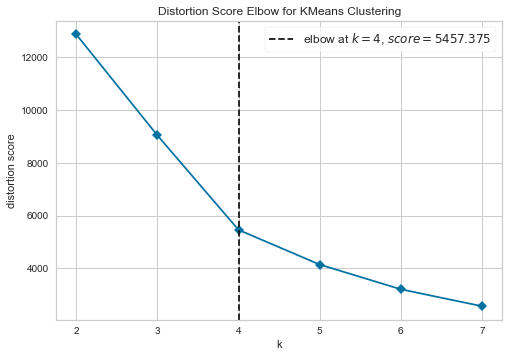

In [33]:
kmeans_wss = KElbowVisualizer( c.KMeans(), k = clusters, timings=False );
kmeans_wss.fit( df7 );
kmeans_wss.show();

## 7.2. Silhouette Score

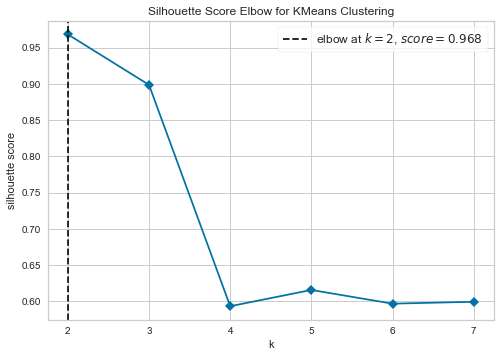

In [34]:
kmeans_sil = KElbowVisualizer( c.KMeans(), k = clusters, metric='silhouette', timings=False );
kmeans_sil.fit( df7 );
kmeans_sil.show();

### 7.2.0. Silhouette Analysis

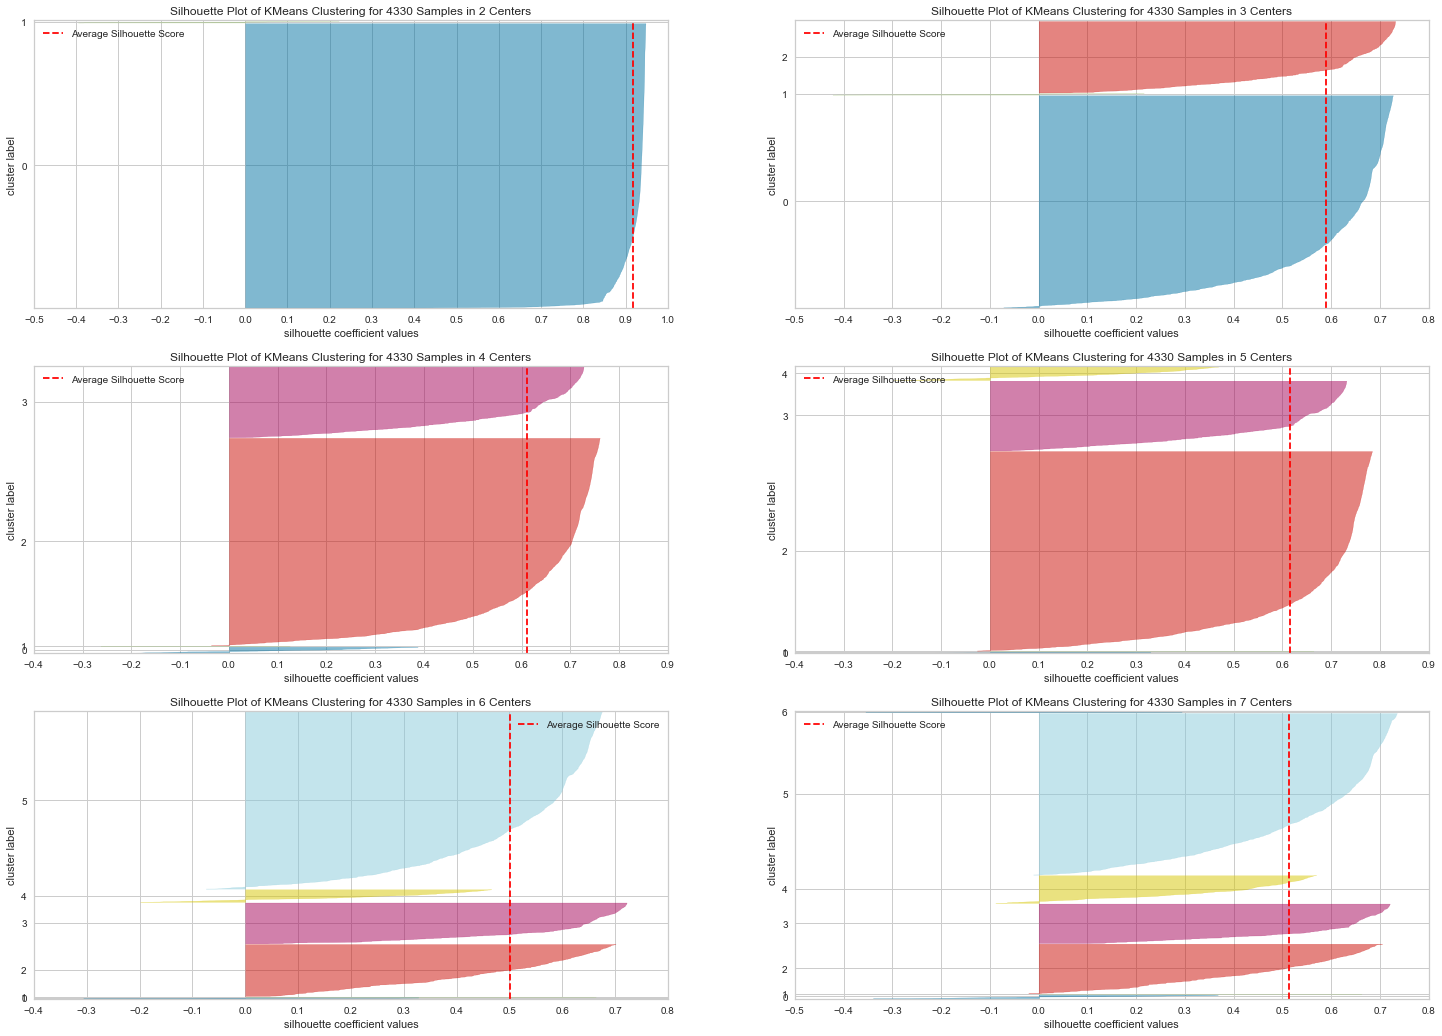

In [35]:
fig, ax = plt.subplots( 3, 2, figsize=( 25, 18 ) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    # plot silhouette visualizers
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( df7 )
    visualizer.finalize()

# 8.0. MACHINE LEARNING

In [36]:
df8 = df7.copy()

## 8.1. K-Means

In [37]:
# model definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( df8 )

# clustering
labels = kmeans.labels_

### Validation

In [38]:
# Within-Cluster Sum of Square ( WSS )
print( f'WSS: { kmeans.inertia_ }' )

# Silhouette Score
print( 'Silhouette Score: {}'.format( m.silhouette_score( df8, labels, metric='euclidean' ) ) )

WSS: 9404.844768603238
Silhouette Score: 0.5895273303328358


# 9.0. CLUSTER ANALYSIS

In [39]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1. Visualization Inspection

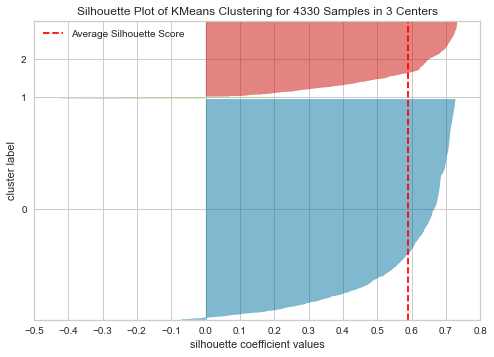

In [40]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( df8 )
visualizer.finalize()

## 9.2. 2D plot

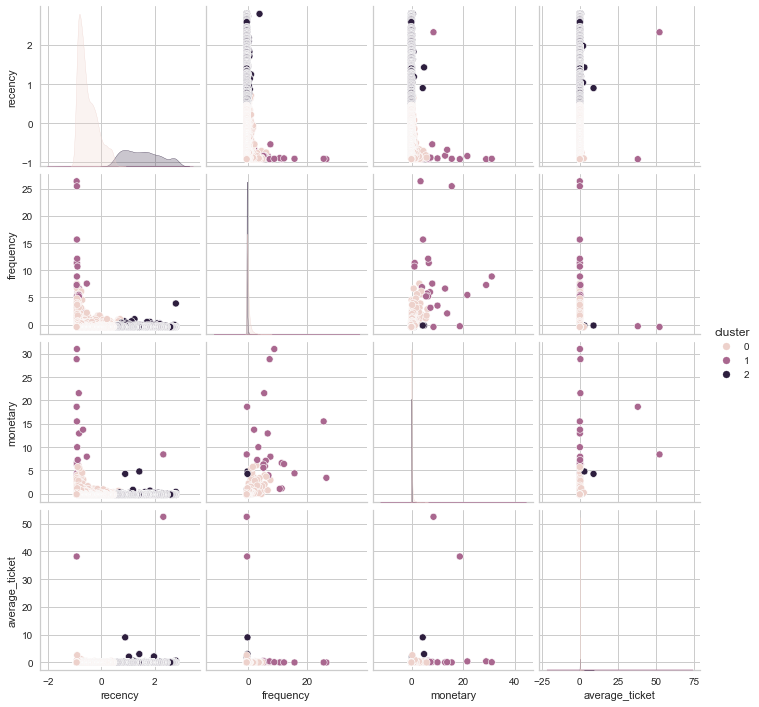

In [41]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz , hue='cluster' );

## 9.3. UMAP

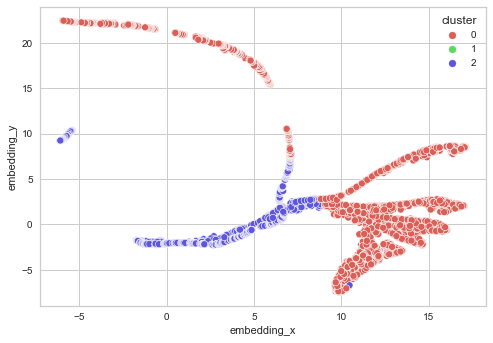

In [42]:
reducer = umap.UMAP( n_neighbors=90, random_state=42 )
embedding = reducer.fit_transform( df8 )

# embedding 
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP 
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', 
                 palette = sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data = df_viz );

## 9.4. Cluster Profile

In [43]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Number of customers
n_customers = df9[['customer_id','cluster']].groupby( 'cluster' ).count().reset_index()

# Avg recency
avg_recency = df9[['recency','cluster']].groupby( 'cluster' ).mean().reset_index()
n_customers = pd.merge( n_customers, avg_recency, on='cluster', how='left' )

# Avg frequency
avg_frequency = df9[['frequency','cluster']].groupby( 'cluster' ).mean().reset_index()
n_customers = pd.merge( n_customers, avg_frequency, on='cluster', how='left' )

# Avg monetary
avg_monetary = df9[['monetary','cluster']].groupby( 'cluster' ).mean().reset_index()
n_customers = pd.merge( n_customers, avg_monetary, on='cluster', how='left' )

# Avg ticket
avg_ticket = df9[['cluster','average_ticket']].groupby( 'cluster' ).mean().reset_index()
n_customers = pd.merge( n_customers, avg_ticket, on='cluster', how='left' )

# Customer Perc
n_customers['percentage'] = 100 * ( n_customers['customer_id'] / n_customers['customer_id'].sum() )

# Sort values
n_customers = n_customers.sort_values( 'monetary', ascending=False )
n_customers

,cluster,customer_id,recency,frequency,monetary,average_ticket,percentage
1,1,22,-0.72,8.44,10.34,4.19,0.51
0,0,3222,-0.51,0.06,-0.02,-0.03,74.41
2,2,1086,1.54,-0.35,-0.16,-0.01,25.08


# 10.0. DEPLOY